# Week IV: Feature Engineering for Signal Processing using Convolutional Neural Networks

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">automatic speech recognition</a> (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">systems</a> are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup



In [ ]:
import os
import pathlib


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython import display
from tqdm.notebook import tqdm as notebook_tqdm

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', 
      cache_subdir='data')

182091776/182082353 [==============================] - 3s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
tf.io.gfile.listdir(str(data_dir))

['go', 'README.md', 'yes', 'up', 'right', 'stop', 'down', 'no', 'left']

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['go' 'yes' 'up' 'right' 'stop' 'down' 'no' 'left']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/down/f4cae173_nohash_0.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
tf.audio.decode_wav(contents=tf.io.read_file(filenames[20]))

DecodeWav(audio=<tf.Tensor: shape=(16000, 1), dtype=float32, numpy=
array([[ 6.1035156e-05],
       [ 6.1035156e-05],
       [ 6.1035156e-05],
       ...,
       [-1.2207031e-04],
       [-1.2207031e-04],
       [-1.2207031e-04]], dtype=float32)>, sample_rate=<tf.Tensor: shape=(), dtype=int32, numpy=16000>)

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Conver to tf dataset:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_files_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_files_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_files_ds = tf.data.Dataset.from_tensor_slices(test_files)

In [ ]:
train_files_ds

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
train_ds = train_files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
val_ds = val_files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
test_ds = test_files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
train_tensors = []
for a in notebook_tqdm(train_ds):
  train_tensors.append(a[0])

  0%|          | 0/6400 [00:00<?, ?it/s]

In [ ]:
min([t.shape[0] for t in train_tensors])

6827

In [ ]:
max([t.shape[0] for t in train_tensors])

16000

In [ ]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensors, maxlen=16000, dtype='float32')

In [ ]:
min([t.shape[0] for t in padded_train])

16000

In [ ]:
val_tensors = []
for a in notebook_tqdm(val_ds):
  val_tensors.append(a[0])
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_tensors, maxlen=16000, dtype='float32')

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
test_tensors = []
for a in notebook_tqdm(test_ds):
  test_tensors.append(a[0])
padded_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensors, maxlen=16000, dtype='float32')

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
print('Train: ', padded_train.shape)
print('Val: ', padded_val.shape)
print('Train: ', padded_test.shape)

Train:  (6400, 16000)
Val:  (800, 16000)
Train:  (800, 16000)


Add channels dimension:

In [ ]:
x_train = tf.expand_dims(padded_train, axis=-1)
x_val = tf.expand_dims(padded_val, axis=-1)
x_test = tf.expand_dims(padded_test, axis=-1)

Validate:

In [ ]:
print('Train: ', x_train.shape)
print('Val: ', x_val.shape)
print('Train: ', x_test.shape)

Train:  (6400, 16000, 1)
Val:  (800, 16000, 1)
Train:  (800, 16000, 1)


Build Y:

In [ ]:
[a for a in train_ds.take(1)]

[(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
  array([-0.00119019, -0.00521851, -0.00808716, ...,  0.00701904,
          0.00646973,  0.00488281], dtype=float32)>,
  <tf.Tensor: shape=(), dtype=string, numpy=b'down'>)]

In [ ]:
train_targets = []
for a in notebook_tqdm(train_ds):
  train_targets.append(a[1].numpy().decode("utf-8"))

  0%|          | 0/6400 [00:00<?, ?it/s]

In [ ]:
val_targets = []
for a in notebook_tqdm(val_ds):
  val_targets.append(a[1].numpy().decode("utf-8"))

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
test_targets = []
for a in notebook_tqdm(test_ds):
  test_targets.append(a[1].numpy().decode("utf-8"))

  0%|          | 0/800 [00:00<?, ?it/s]

One hot encoding:

In [ ]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(train_targets).reshape(-1, 1)).toarray()

In [ ]:
y_train.shape

(6400, 8)

In [ ]:
y_val = ohe.transform(np.array(val_targets).reshape(-1, 1)).toarray()
y_test = ohe.transform(np.array(test_targets).reshape(-1, 1)).toarray()

In [ ]:
y_val.shape, y_test.shape

((800, 8), (800, 8))

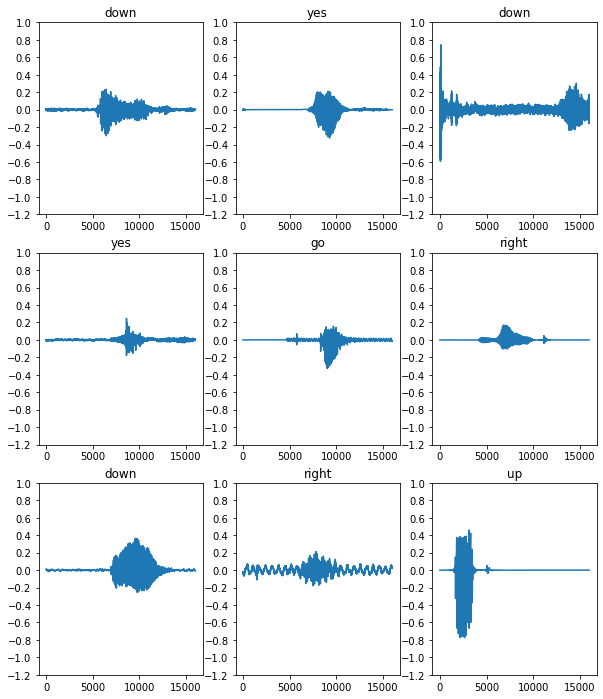

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, audio in enumerate(padded_train[:9]):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(train_targets[i])

plt.show()

In [ ]:
display.display(display.Audio(x_test[0, :, 0], rate=16000))
label_index = np.argmax(y_test[0])
label_name = ohe.get_feature_names_out()[label_index][3:]
print(label_name)

stop


In [ ]:
display.display(display.Audio(x_test[1, :, 0], rate=16000))
label_index = np.argmax(y_test[1])
label_name = ohe.get_feature_names_out()[label_index][3:]
print(label_name)

go


## 1D Conv model

In [ ]:
accuracies = {}

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Normalization, Input, Dropout, BatchNormalization, GlobalAveragePooling1D, LSTM, GRU
from tensorflow.keras.utils import plot_model

In [ ]:
norm_layer = Normalization()
norm_layer.adapt(data=x_train)

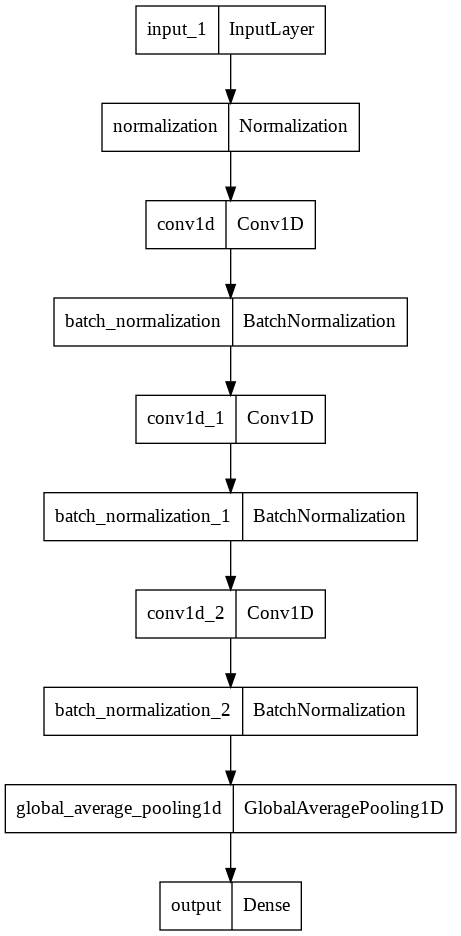

In [ ]:
model = Sequential(name='Conv1')
model.add(Input(shape=(16000, 1)))
model.add(norm_layer)

model.add(Conv1D(8, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(8, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling1D())
model.add(Dense(8, activation='softmax', name='output'))
plot_model(model)

In [ ]:
model.summary()

Model: "Conv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16000, 1)         3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 15998, 8)          32        
                                                                 
 batch_normalization (BatchN  (None, 15998, 8)         32        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 15996, 8)          200       
                                                                 
 batch_normalization_1 (Batc  (None, 15996, 8)         32        
 hNormalization)                                                 
                                                             

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
def create_checkpoint(model_name):
  checkpoint_dir = os.path.join('/content/drive/My Drive/audio_checkpoints', model_name)
  checkpoint_path = os.path.join(checkpoint_dir, model_name + '.h5')

  checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      save_best_only=True,
      monitor='val_accuracy',
      mode='max',
      verbose=1)
  return checkpoint_callback, checkpoint_path

In [ ]:
checkpoint_callback, checkpoint_path = create_checkpoint(model.name)

In [ ]:
if os.path.exists(checkpoint_path):
  model = models.load_model(checkpoint_path)
else:
  model.fit(x_train, 
            y_train, 
            validation_data=(x_val, y_val), 
            epochs=10, 
            batch_size=32,
            callbacks=[checkpoint_callback]
            )

In [ ]:
accuracies[model.name] = model.evaluate(x_test, y_test)[1]

25/25 [==============================] - 12s 29ms/step - loss: 1.6988 - accuracy: 0.3887


In [ ]:
y_pred_1d = model.predict(x_test)

## Bigger 1D model

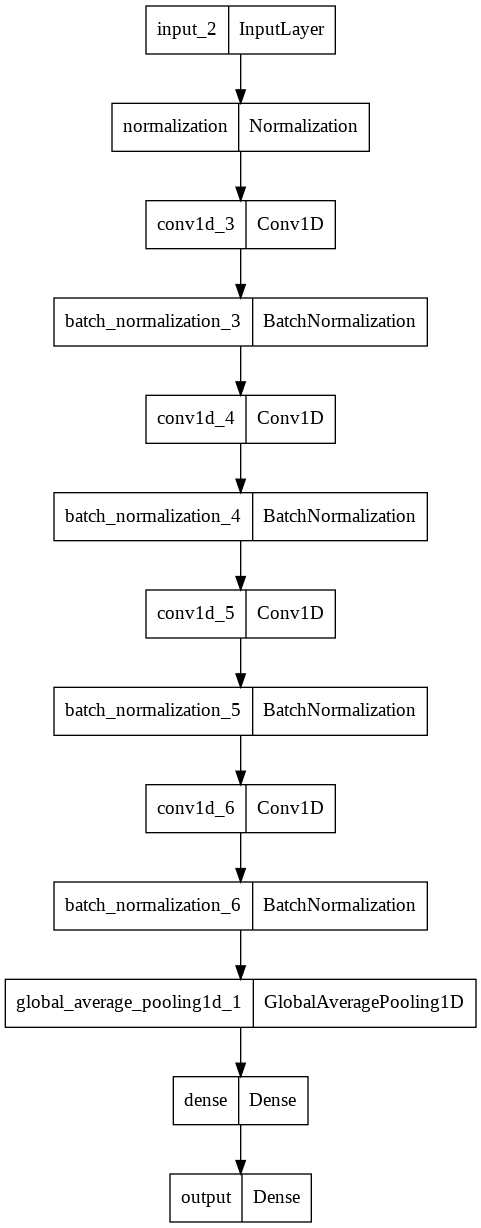

In [ ]:
model = Sequential(name='Conv1_big')
model.add(Input(shape=(16000, 1)))
model.add(norm_layer)

model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax', name='output'))
plot_model(model)

In [ ]:
model.summary()

Model: "Conv1_big"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16000, 1)         3         
 n)                                                              
                                                                 
 conv1d_3 (Conv1D)           (None, 15998, 16)         64        
                                                                 
 batch_normalization_3 (Batc  (None, 15998, 16)        64        
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 15996, 32)         1568      
                                                                 
 batch_normalization_4 (Batc  (None, 15996, 32)        128       
 hNormalization)                                                 
                                                         

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
checkpoint_callback, checkpoint_path = create_checkpoint(model.name)

In [ ]:
if os.path.exists(checkpoint_path):
  model = models.load_model(checkpoint_path)
else:
  model.fit(x_train, 
            y_train, 
            validation_data=(x_val, y_val), 
            epochs=10, 
            batch_size=32,
            callbacks=[checkpoint_callback]
            )

In [ ]:
accuracies[model.name] = model.evaluate(x_test, y_test)[1]

25/25 [==============================] - 3s 100ms/step - loss: 1.2698 - accuracy: 0.5213


In [ ]:
y_pred_1d = model.predict(x_test)

## Random forest

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, verbose=10, n_jobs=-1)

In [ ]:
x_train_numpy = x_train.numpy()[:, :, 0]
x_test_numpy = x_test.numpy()[:, :, 0]
x_train_numpy.shape

(6400, 16000)

In [ ]:
y_train_numpy = np.array(train_targets)
y_test_numpy = np.array(test_targets)

In [ ]:
y_train_numpy[0]

'down'

In [ ]:
le = LabelEncoder()
y_train_numpy = le.fit_transform(y_train_numpy)
y_test_numpy = le.transform(y_test_numpy)

In [ ]:
y_train_numpy[0]

0

In [ ]:
rf.fit(x_train_numpy, y_train_numpy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s


building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.5s


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   12.3s


building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   16.2s


building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.0s


building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.0s finished


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42, verbose=10)

In [ ]:
y_pred_rf = rf.predict(x_test_numpy)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
accuracies['Random forest'] = accuracy_score(y_test_numpy, y_pred_rf)

In [ ]:
accuracies['Random forest']

0.22125

## Feature engineering

We're going to use the Short-time Fourier transform (STFT). Using Fourier transforms can help us extract useful features from signals. 

Here's an example of how Fourier can decompose an image:

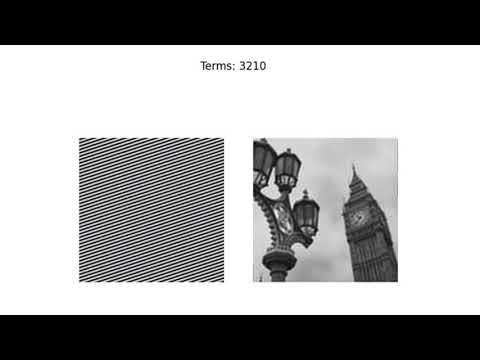

In [ ]:
# Full video: https://www.youtube.com/watch?time_continue=21&v=VYuqcv1dFWM&feature=emb_title
from IPython.display import YouTubeVideo
YouTubeVideo('VYuqcv1dFWM', width=1200, height=800)

We can use STFT to convert the signal into images called spectograms:

In [ ]:
x_train_spec = tf.signal.stft(padded_train, 
                              frame_length=255, 
                              frame_step=128)
x_train_spec = tf.abs(x_train_spec)
x_train_spec.shape

TensorShape([6400, 124, 129])

In [ ]:
x_test_spec = tf.signal.stft(padded_test, 
                             frame_length=255, 
                             frame_step=128)
x_test_spec = tf.abs(x_test_spec)
x_test_spec.shape

TensorShape([800, 124, 129])

In [ ]:
x_val_spec = tf.signal.stft(padded_val, 
                            frame_length=255, 
                            frame_step=128)
x_val_spec = tf.abs(x_val_spec)
x_val_spec.shape

TensorShape([800, 124, 129])

In [ ]:
x_train_spec = tf.expand_dims(x_train_spec, axis=-1)
x_val_spec = tf.expand_dims(x_val_spec, axis=-1)
x_test_spec = tf.expand_dims(x_test_spec, axis=-1)

In [ ]:
x_train_spec.shape, x_val_spec.shape, x_test_spec.shape

(TensorShape([6400, 124, 129, 1]),
 TensorShape([800, 124, 129, 1]),
 TensorShape([800, 124, 129, 1]))

Let's plot a few images:

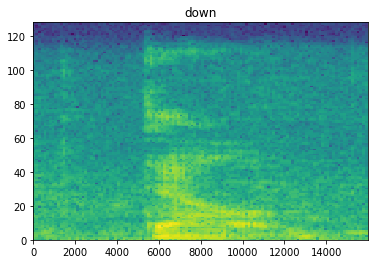

In [ ]:
spectrogram = x_train_spec[0].numpy()[:, :, 0]

plt.title(train_targets[0])
log_spec = np.log(spectrogram.T + np.finfo(float).eps)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
Y = range(height)
plt.pcolormesh(X, Y, log_spec)

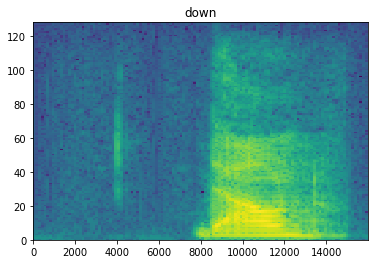

In [ ]:
spectrogram = x_train_spec[20].numpy()[:, :, 0]

plt.title(train_targets[20])
log_spec = np.log(spectrogram.T + np.finfo(float).eps)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
Y = range(height)
plt.pcolormesh(X, Y, log_spec)

## Build 2D model

In [ ]:
from keras.layers import Conv2D, Resizing, Dropout, MaxPooling2D

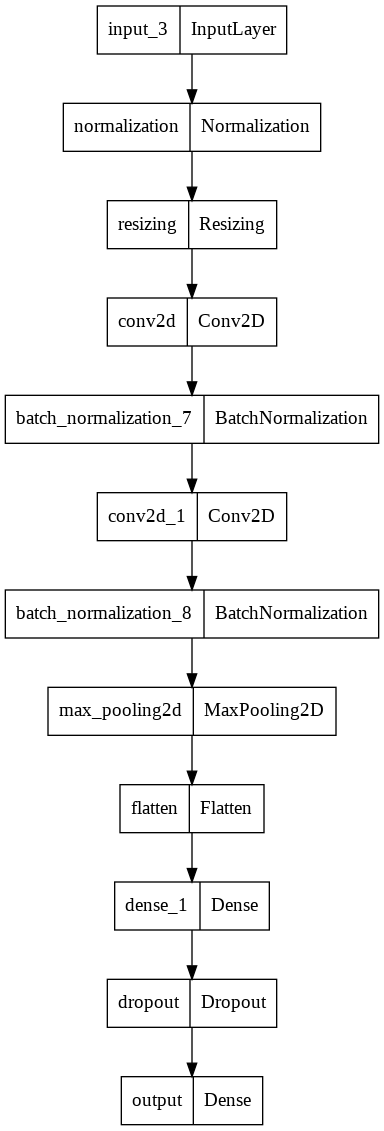

In [ ]:
model = Sequential(name='Conv2')
model.add(Input(shape=(124, 129, 1)))
model.add(norm_layer)
model.add(Resizing(32, 32))

model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax', name='output'))
plot_model(model)

In [ ]:
model.summary()

Model: "Conv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256   

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
checkpoint_callback, checkpoint_path = create_checkpoint(model.name)

In [ ]:
if os.path.exists(checkpoint_path):
  model = models.load_model(checkpoint_path)
else:
  model.fit(x_train_spec, 
            y_train, 
            validation_data=(x_val_spec, y_val), 
            epochs=10, 
            batch_size=32,
            callbacks=[checkpoint_callback]
            )

In [ ]:
accuracies[model.name] = model.evaluate(x_test_spec, y_test)[1]

25/25 [==============================] - 0s 6ms/step - loss: 0.4123 - accuracy: 0.8537


## Transfer learning

In [ ]:
x_train_spec.shape

TensorShape([6400, 124, 129, 1])

Transform to 3 channels:

In [ ]:
x_train_rgb = np.concatenate([x_train_spec] * 3, axis=-1)
x_val_rgb = np.concatenate([x_val_spec] * 3, axis=-1)
x_test_rgb = np.concatenate([x_test_spec] * 3, axis=-1)

In [ ]:
x_train_rgb.shape

(6400, 124, 129, 3)

In [ ]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(124, 129, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg_model.trainable = False

In [ ]:
input = Input(shape=(124, 129, 3))

x = vgg_model(input)
x = layers.GlobalMaxPooling2D()(x)
x = Dense(128)(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

transfer_model = models.Model(input, output, name='Transfer')

In [ ]:
transfer_model.summary()

Model: "Transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 124, 129, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 4, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                          

In [ ]:
transfer_model.compile(optimizer='adam', 
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                      metrics=['accuracy'])

In [ ]:
transfer_model._name = 'Transfer'

In [ ]:
checkpoint_callback, checkpoint_path = create_checkpoint(transfer_model.name)

In [ ]:
if os.path.exists(checkpoint_path):
  transfer_model = models.load_model(checkpoint_path)
else:
  transfer_model.fit(x_train_rgb, 
                     y_train, 
                     validation_data=(x_val_rgb, y_val), 
                     epochs=10, 
                     batch_size=32,
                     callbacks=[checkpoint_callback]
                     )

In [ ]:
accuracies[transfer_model.name] = transfer_model.evaluate(x_test_rgb, y_test, batch_size=32)[1]

25/25 [==============================] - 5s 107ms/step - loss: 0.7126 - accuracy: 0.7437


## Evaluation and noise

In [ ]:
pred = model.predict(x_test_spec[:10, :, :])
pred.shape

(10, 8)

In [ ]:
pred = np.array([np.argmax(y) for y in pred])
pred

array([5, 1, 4, 3, 4, 1, 7, 0, 5, 0])

In [ ]:
regular_pred = [ohe.get_feature_names_out()[c][3:] for c in pred]
pred = [ohe.get_feature_names_out()[c][3:] for c in pred]
pred

['stop', 'go', 'right', 'no', 'right', 'go', 'yes', 'down', 'stop', 'down']

In [ ]:
display.display(display.Audio(x_test[50, :, 0], rate=16000))

In [ ]:
noisy = x_test[50, :, 0] + 0.01 * np.random.normal(size=x_test[50, :, 0].shape)

In [ ]:
display.display(display.Audio(noisy, rate=16000))

In [ ]:
y_pred_model_spec_noise = model.predict(x_test_spec + 0.01 * np.random.normal(size=x_test_spec.shape))
print('Accuracy with noise is: ', accuracy_score(y_test_numpy, np.array([np.argmax(y) for y in y_pred_model_spec_noise])))

Accuracy with noise is:  0.82125


In [ ]:
command_names = [c[3:] for c in ohe.get_feature_names_out()]

In [ ]:
y_pred_spec = model.predict(x_test_spec)

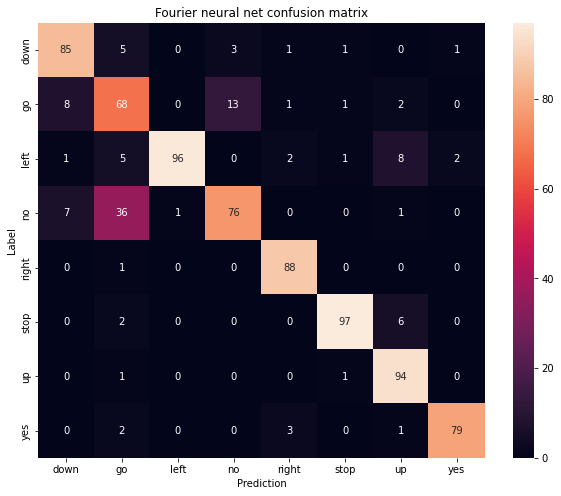

In [ ]:
confusion_mtx = tf.math.confusion_matrix(np.array([np.argmax(y) for y in y_test]), 
                                         np.array([np.argmax(y) for y in y_pred_spec]))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=command_names,
            yticklabels=command_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Fourier neural net confusion matrix')

plt.show()

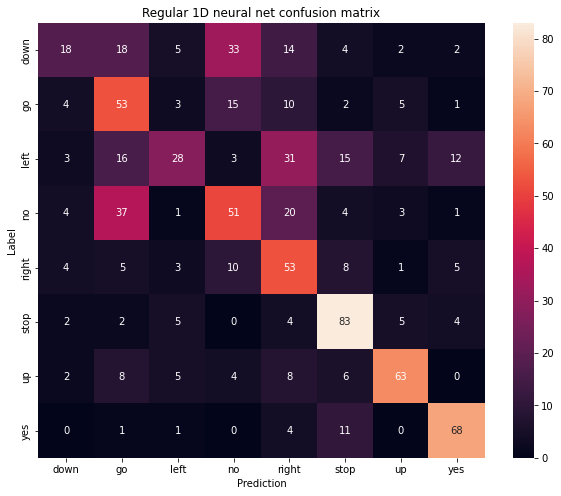

In [ ]:
confusion_mtx = tf.math.confusion_matrix(np.array([np.argmax(y) for y in y_test]), 
                                         np.array([np.argmax(y) for y in y_pred_1d]))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=command_names,
            yticklabels=command_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Regular 1D neural net confusion matrix')
plt.show()

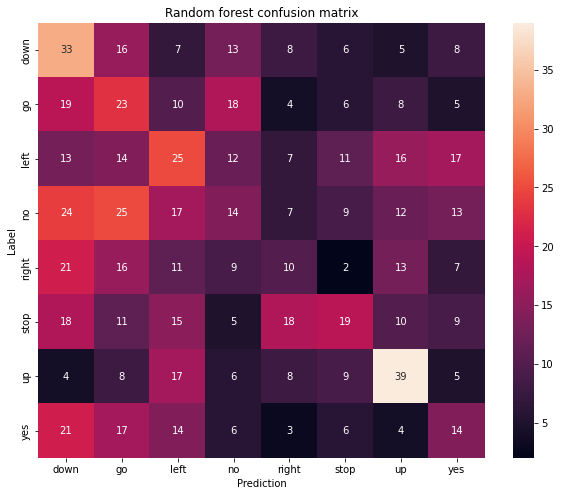

In [ ]:
confusion_mtx = tf.math.confusion_matrix(np.array([np.argmax(y) for y in y_test]), 
                                         np.array([y for y in y_pred_rf]))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=command_names,
            yticklabels=command_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Random forest confusion matrix')
plt.show()

## Adding noise

In [ ]:
model = models.load_model(checkpoint_path)

In [ ]:
model._name = 'Conv2_noise'

In [ ]:
model.name

'Conv2_noise'

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [ ]:
checkpoint_callback, checkpoint_path = create_checkpoint(model.name)

In [ ]:
if os.path.exists(checkpoint_path):
  model = models.load_model(checkpoint_path)
else:
  model.fit(x_train_spec + 0.1 * np.random.normal(size=x_train_spec.shape), 
            y_train, 
            validation_data=(x_val_spec + 0.1 * np.random.normal(size=x_val_spec.shape), y_val), 
            epochs=10, 
            batch_size=32,
            callbacks=[checkpoint_callback]
            )

In [ ]:
accuracies[model.name] = model.evaluate(x_test_spec + 0.1 * np.random.normal(size=x_val_spec.shape), y_test)[1]

25/25 [==============================] - 0s 5ms/step - loss: 0.3758 - accuracy: 0.8712


In [ ]:
accuracies

{'Conv1': 0.38874998688697815,
 'Conv1_big': 0.5212500095367432,
 'Conv2': 0.8537499904632568,
 'Conv2_noise': 0.8712499737739563,
 'Random forest': 0.22125,
 'Transfer': 0.7437499761581421}

In [ ]:
accruacy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
accruacy_df

,Accuracy
Conv1,0.38875
Conv1_big,0.52125
Random forest,0.22125
Conv2,0.85375
Transfer,0.74375
Conv2_noise,0.87125


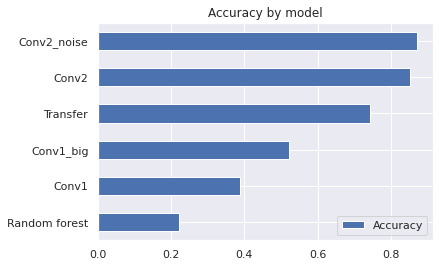

In [ ]:
sns.set()
accruacy_df.sort_values(by='Accuracy').plot(kind='barh', title='Accuracy by model')